In [54]:
from lib.sspnet_data_sampler import SSPNetDataSampler

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F

import copy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [73]:
class RNNClassifier(nn.Module):
    def __init__(self, in_size, h_size=128):
        super().__init__()
        self.lstm = nn.LSTM(in_size, h_size)
        self.linear = nn.Linear(h_size, 2)
        
        self._h_size = h_size
        self._hidden = None
        
    def forward(self, x):
        x, self._hidden = self.lstm(x.float(), self._hidden)
        x = self.linear(x)
        return F.softmax(x, dim=-1)
        
    def clear(self, seq_len):
        self._hidden = (torch.zeros(1, seq_len, self._h_size).float().cuda(), torch.zeros(1, seq_len, self._h_size).float().cuda())
        
class Classifier:
    def __init__(self, model):
        self._model = model
        
    def classify(self, x):
        result = self._model(torch.tensor(x).cuda())
        return torch.argmax(result, dim=len(result.size()) - 1).detach().cpu().numpy(), result.detach().cpu().numpy()[:, :, 1]
        
    def clear(self, seq_len):
        self._model.clear(seq_len)
        
def fit(model, optimizer, batch):
    x, y_tmp = batch
    x = torch.tensor(x).cuda()
    y = torch.zeros(y_tmp.shape[0], y_tmp.shape[1], 2).float()
    
    for i in range(y.size(0)):
        for j in range(y.size(1)):
            y[i][j][y_tmp[i][j]] = 1
    
    y = y.cuda()
    
    loss = 0
    model.clear(x.size(1))
    y_pred = model(x)
    
    loss = F.mse_loss(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()
    
def train(X, Y, epochs=45, batch_size=128):
    X = np.array(X)
    model = RNNClassifier(X.shape[-1])
    model.to(torch.device("cuda"))
    optimizer = Adam(model.parameters())
    
    batches = []
    for i in range(0, len(X), batch_size):
        batches.append((X[i:min(i+batch_size, len(X))], Y[i:min(i+batch_size, len(X))]))
    
    for i in range(epochs):
        ts = time.time()
        loss = 0
        for batch in batches:
            l = fit(model, optimizer, batch) * len(batch[0])
            loss += l
        print(i+1, "Loss:", loss / len(X), "Time:", time.time() - ts)
        
    return model

In [49]:
#sampler = SSPNetDataSampler("corpus")
#data = sampler.create_sampled_df(0.1, save_path='corpus.csv')
data = pd.read_csv('corpus.csv')

In [50]:
data = np.array(data.drop(columns='SNAME'))
X = data[:, :-1]
Y = data[:, -1].astype(np.uint8)

seq_len = 110
X = X.reshape((X.shape[0] // seq_len, seq_len, X.shape[1]))
Y = Y.reshape((Y.shape[0] // seq_len, seq_len))

devider = int(len(X) * 0.9)
train_X = X[:devider]
train_Y = Y[:devider]
test_X = X[devider:]
test_Y = Y[devider:]

In [51]:
model = train(train_X, train_Y, 40, 256)

1 Loss: 0.22877688677463043 Time: 3.6771602630615234
2 Loss: 0.1126649198324784 Time: 3.352992057800293
3 Loss: 0.06665203852328475 Time: 3.3639698028564453
4 Loss: 0.04898246382853211 Time: 3.4417643547058105
5 Loss: 0.04170520218563777 Time: 4.2346696853637695
6 Loss: 0.03846226391911942 Time: 3.754948616027832
7 Loss: 0.03676792875095772 Time: 4.0960774421691895
8 Loss: 0.03579004456761018 Time: 3.782839775085449
9 Loss: 0.03512906137822072 Time: 4.412203311920166
10 Loss: 0.03461070810753076 Time: 4.085062026977539
11 Loss: 0.03424027127700819 Time: 3.50266170501709
12 Loss: 0.03399337641062266 Time: 3.34604811668396
13 Loss: 0.03378366567845366 Time: 3.3799538612365723
14 Loss: 0.033599957148629636 Time: 3.3081166744232178
15 Loss: 0.03347434014784326 Time: 3.3021719455718994
16 Loss: 0.033325654575249275 Time: 3.3749709129333496
17 Loss: 0.033207990059592 Time: 3.3071515560150146
18 Loss: 0.03315028320575623 Time: 3.2792255878448486
19 Loss: 0.03311126164816493 Time: 3.5076136589

(10, 110, 8)


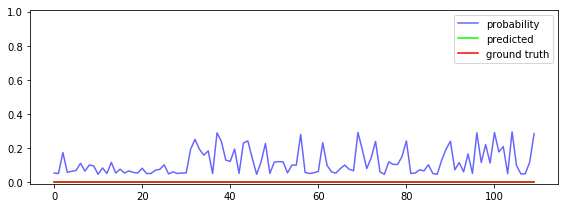

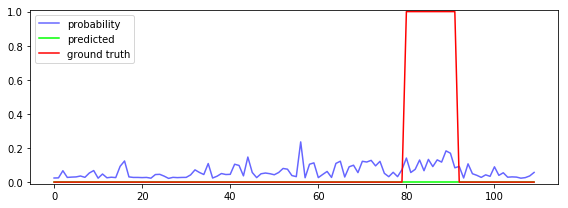

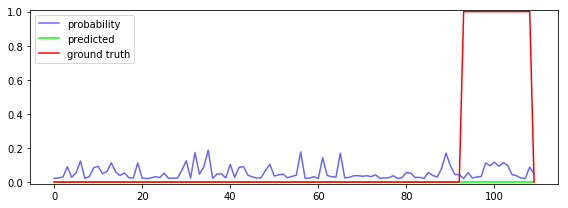

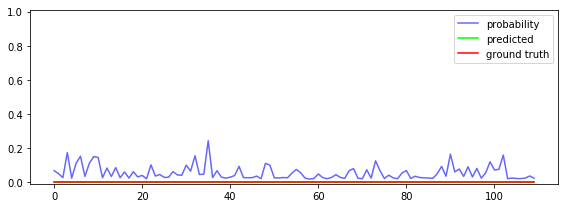

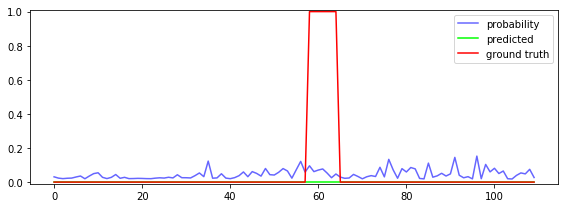

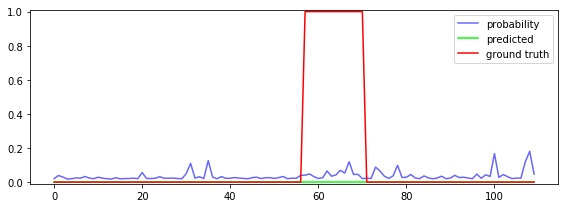

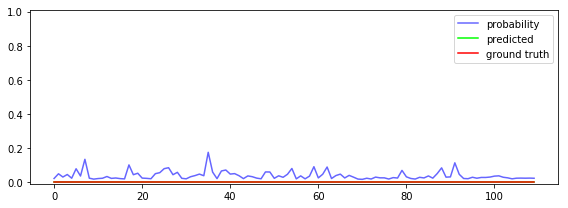

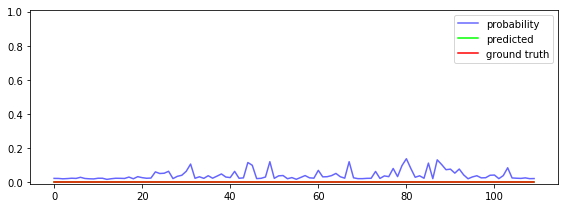

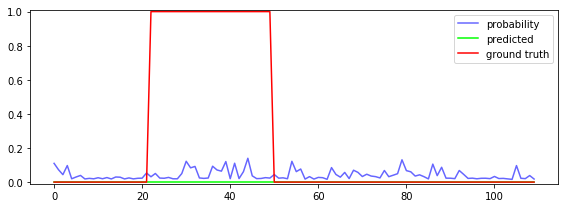

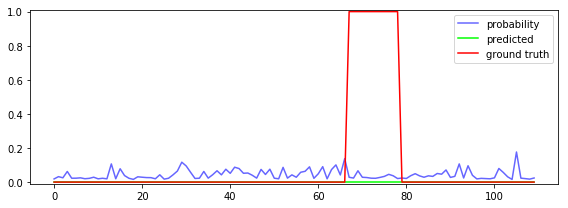

In [77]:
def plot_proba(y, y_pred, y_proba):
    plt.figure(figsize=(8, 3))
    x = list(range(len(y)))
    plt.plot(x, y_proba, label="probability", color=(0, 0, 1, 0.6))
    plt.plot(x, y_pred, label="predicted", color=(0, 1, 0))
    plt.plot(x, y, label="ground truth", color=(1, 0, 0))
    plt.ylim(-0.01, 1.01)
    plt.legend()
    plt.tight_layout()
    plt.show()

classifier = Classifier(model)

y = train_Y[:10]
x = train_X[:10]
print(x.shape)
classifier.clear(x.shape[1])
y_pred, y_proba = classifier.classify(x)
for i in range(10):
    plot_proba(y[i], y_pred[i], y_proba[i])